In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
sns.set(style="darkgrid")

import sys
sys.path.insert(1, '../../lab_1/')

PATH_TO_DATA = '../../lab_1/data/'

from functions import (get_df_with_return, 
                       get_df_with_mean_std_return,
                       get_portfolio_risk,
                       minimize_portfolio,
                       calculate_efficient_frontier,
                       plot_efficient_frontier)

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [8]:
history_data = pd.read_csv(PATH_TO_DATA + 'prepared_data.csv', encoding='utf-16')
index_data = pd.read_csv(PATH_TO_DATA + 'index_data.csv', encoding='utf-16')
stock_characteristics = pd.read_csv(PATH_TO_DATA + 'data_characteristics.csv', encoding='utf-16').set_index('SECID')
stock_return = pd.read_csv(PATH_TO_DATA + 'return_data.csv', encoding='utf-16', index_col=0)

In [9]:
stock_characteristics['RISK_FEE'] = stock_characteristics.MEAN_RETURN / stock_characteristics.STD_RETURN
top_10_by_risk_fee = stock_characteristics.sort_values(by='RISK_FEE', ascending=False).head(10).index
stock_characteristics = stock_characteristics.filter(top_10_by_risk_fee, axis=0)
stock_return = stock_return[top_10_by_risk_fee]

In [10]:
index_data_with_return = get_df_with_return(index_data, price_name='CLOSE', first_day_value=0.0)
index_data_characteristics = get_df_with_mean_std_return(index_data_with_return[['SECID', 'RETURN']].copy()).groupby('SECID').first().reset_index().drop(columns=['RETURN'])
index_return = index_data_with_return.RETURN
index_mean_return = index_data_characteristics.MEAN_RETURN[0]
index_std_return = index_data_characteristics.STD_RETURN[0]

# One factor model

In [ ]:
def get_alpha_beta(stock_return, index_return):

    alpha_vec = []
    beta_mat = []
    stocks_num = stock_return.shape[1]
    reg = LinearRegression()

    for i in range(0, stocks_num):

        reg.fit(np.array(index_return).reshape(len(stock_return), 1),
                np.array(stock_return.iloc[:, i]).reshape(len(stock_return), 1))
        
        alpha_vec.append(reg.intercept_[0])
        beta_mat.append(reg.coef_[0,0])

    alpha_vec = np.array(alpha_vec)
    beta_mat = np.array(beta_mat)
            
    return alpha_vec, beta_mat

In [12]:
def get_estimations(stock_characteristics, index_return, alpha, beta):
    linear_stocks_mean_return = []
    linear_stocks_std_return = []
    linear_stocks_mean_noise = []
    linear_stocks_var_noise = []
    noise_matrix = []

    for i in range(stock_return.shape[1]):
        estimated_mean_returns = alpha[i] + beta[i] * index_return
        noises = estimated_mean_returns - stock_return.iloc[:, i].values
        noise_matrix.append(noises.to_list())
        linear_stocks_mean_return.append(estimated_mean_returns.mean())
        linear_stocks_mean_noise.append(noises.mean())
        linear_stocks_var_noise.append(noises.var()) 
        linear_stocks_std_return.append(np.sqrt(np.var(index_return) * beta[i]**2 + noises.var()))
        
    sharp_ratio = np.divide(linear_stocks_mean_return, linear_stocks_std_return)
    stock_characteristics_estimated = pd.DataFrame(data={'SECID' : stock_characteristics.index, 
                                                    'MEAN_RETURN' : linear_stocks_mean_return,
                                                    'STD_RETURN' : linear_stocks_std_return,
                                                    'SHARP_RATIO' : sharp_ratio,
                                                    'MEAN_NOISE' : linear_stocks_mean_noise,
                                                    'VAR_NOISE' : linear_stocks_var_noise})
    return stock_characteristics_estimated, noise_matrix

In [13]:
alpha, beta = get_alpha_beta(stock_return, index_return)
    
stock_characteristics_estimated, noise_matrix = get_estimations(stock_characteristics, index_return, alpha, beta)

Проверим применимость модели к рынку.\
Видно, что мат.ожидание шума на всех активах очень близко к нулю, предположение однофакторной модели о нулевом мат.ожидании выполняется.

In [14]:
stock_characteristics_estimated

,SECID,MEAN_RETURN,STD_RETURN,SHARP_RATIO,MEAN_NOISE,VAR_NOISE
0,NVTK,0.001920,0.017301,0.110975,2.458663e-19,0.000205
1,NKNCP,0.001392,0.013119,0.106140,3.278218e-19,0.000157
2,AGRO,0.001292,0.012207,0.105882,1.639109e-19,0.000132
3,TATN,0.001638,0.015589,0.105048,-4.370957e-19,0.000152
4,LKOH,0.001491,0.015891,0.093838,3.414810e-19,0.000112
5,ROSN,0.001467,0.015937,0.092061,3.278218e-19,0.000153
6,SIBN,0.001407,0.015439,0.091154,1.639109e-19,0.000192
7,SNGSP,0.001268,0.014447,0.087791,1.639109e-19,0.000166
8,TATNP,0.001380,0.016239,0.084951,1.092739e-19,0.000231
9,AKRN,0.000713,0.008924,0.079869,0.000000e+00,0.000071


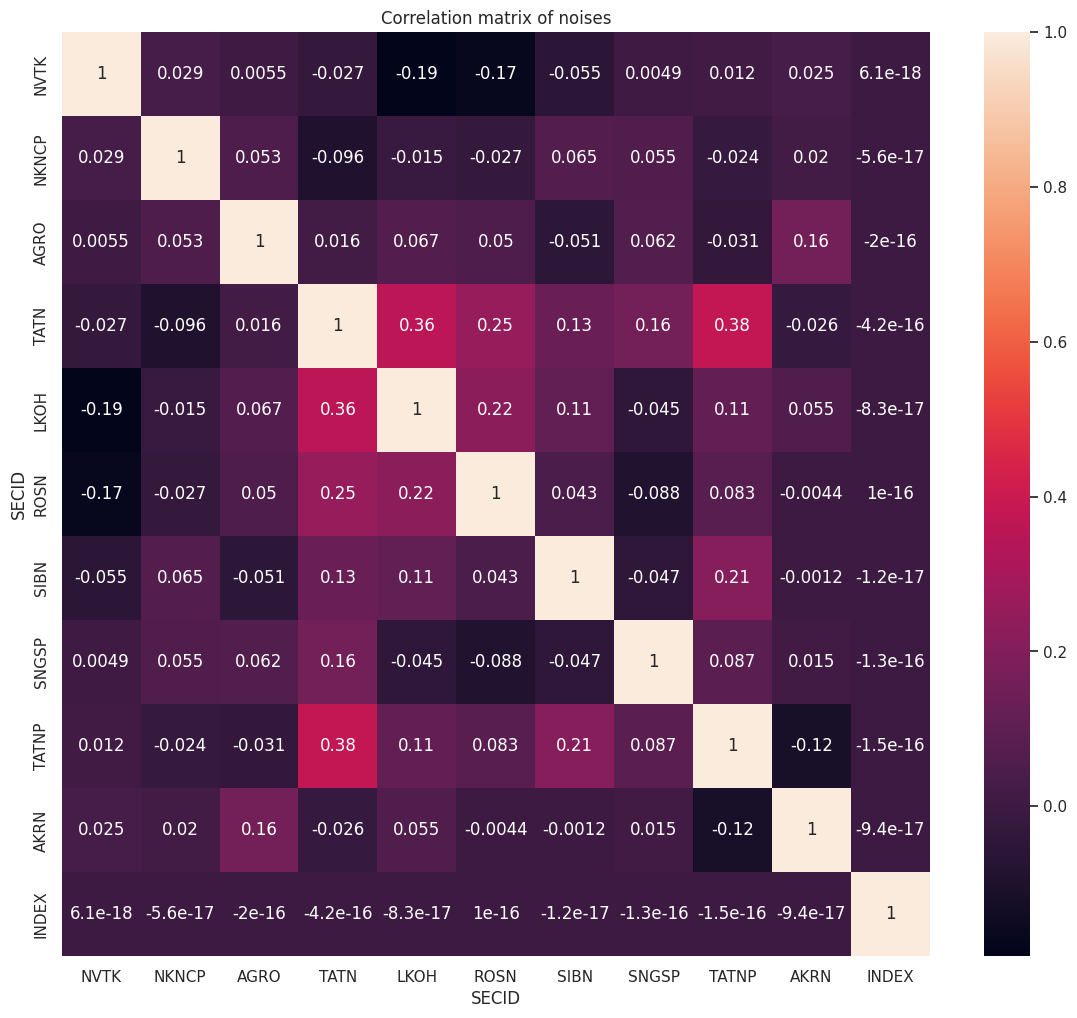

In [15]:
m = pd.DataFrame(np.array(noise_matrix).T, columns=stock_characteristics.index)
m['INDEX'] = index_return
plt.figure(figsize=(14, 12))
sns.heatmap(m.corr(), annot = True)
plt.title('Correlation matrix of noises')
plt.show()

Условие отсутствия попарной корреляции шумов не выполняется: большая часть корреляций относительно близки к нулю, но есть исключения.\
Однако выполняется условие отсутствия попарной корреляции доходности индекса(фактора) и шума. Проверим модель на практике.

In [94]:
def get_covariation(beta, linear_stocks_square_noise, index_return): 
    return np.diag((beta.T @ beta).item() * np.var(index_return) + np.array(linear_stocks_square_noise))

cov_matrix = get_covariation(beta, stock_characteristics_estimated.VAR_NOISE, index_return)

In [17]:
def get_optimal_portfolio(stock_characteristics_estimated, beta, index_std_return):
    numerator = (index_std_return**2) * np.sum(beta * stock_characteristics_estimated.MEAN_RETURN / stock_characteristics_estimated.VAR_NOISE)
    denominator = 1 + (index_std_return**2) * np.sum(beta**2 / stock_characteristics_estimated.VAR_NOISE)
    A = numerator / denominator

    x = ((stock_characteristics_estimated.MEAN_RETURN / beta) - A) * beta / stock_characteristics_estimated.STD_RETURN
    x = x / np.sum(x)
    return x

In [18]:
opt_portfolio = get_optimal_portfolio(stock_characteristics_estimated, beta, index_std_return)
opt_portfolio_mean = np.dot(opt_portfolio, stock_characteristics.MEAN_RETURN)
opt_portfolio_std = get_portfolio_risk(opt_portfolio, stock_return.cov())

In [19]:
result = pd.DataFrame({'SECID' : stock_characteristics.index, 'weights' : opt_portfolio})
display(result.T)

,0,1,2,3,4,5,6,7,8,9
SECID,NVTK,NKNCP,AGRO,TATN,LKOH,ROSN,SIBN,SNGSP,TATNP,AKRN
weights,0.110776,0.218971,0.196772,0.068427,-0.031635,0.015612,0.100559,0.084226,0.121025,0.115266


In [20]:
min_risk_portfolio_std_with_short, min_risk_portfolio_return_with_short, portfolio_stds_with_short, portfolio_returns_with_short = calculate_efficient_frontier(stock_characteristics,
                                                                                                                    stock_return.cov(),
                                                                                                                    short_sales=True)

In [21]:
markowitz_portfolio_with_short = np.array([0.125561, 0.211534, 0.209409, 0.073487, -0.069671, 0.053796, 0.089291, 0.062744, 0.088052, 0.155797])
markowitz_mean_with_short = np.dot(markowitz_portfolio_with_short, stock_characteristics.MEAN_RETURN)
markowitz_std_with_short = get_portfolio_risk(markowitz_portfolio_with_short, stock_return.cov())

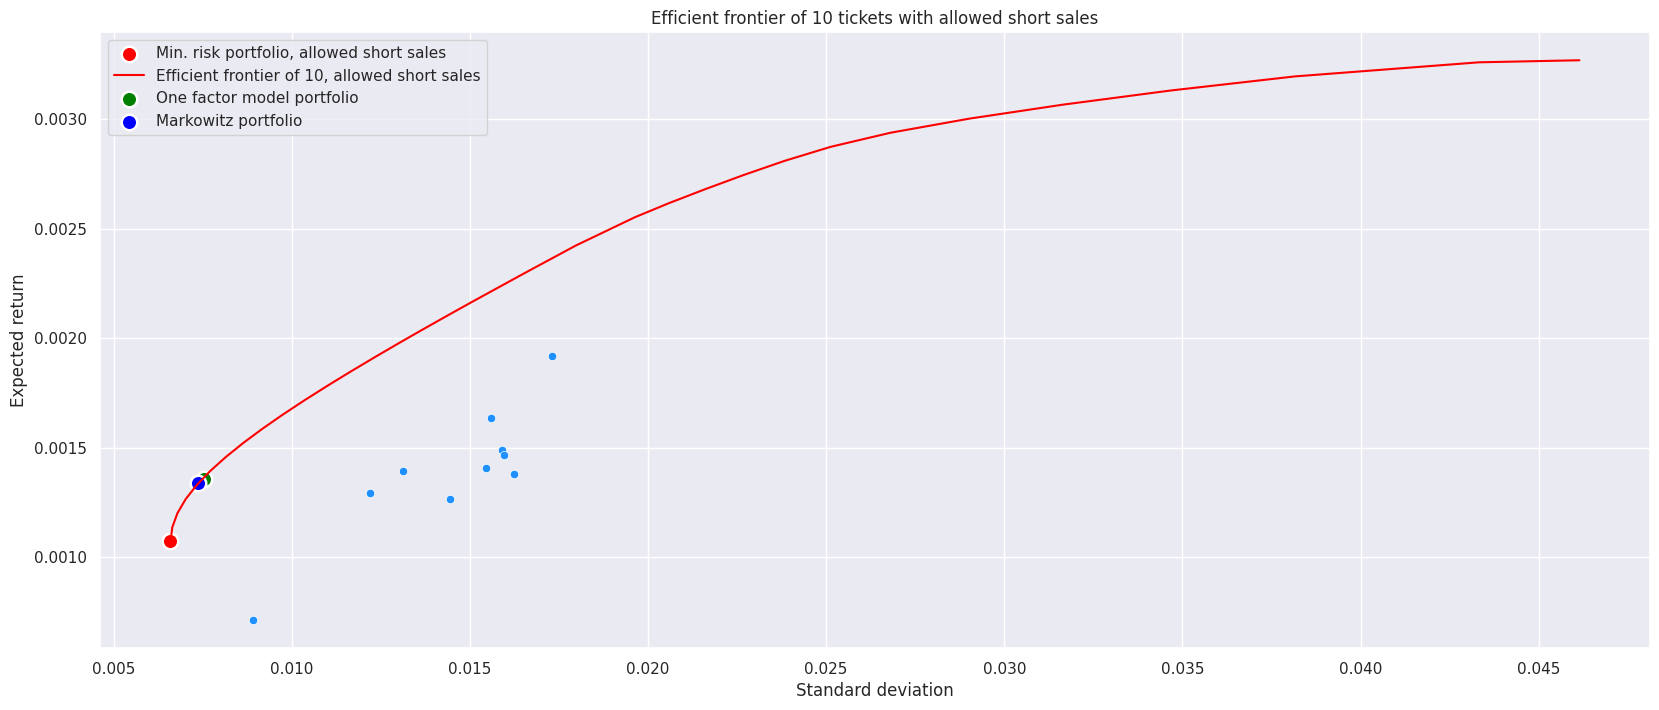

In [22]:
plt.figure(figsize=(20,8))
plot_efficient_frontier(stock_characteristics, 
                        min_risk_portfolio_std_with_short, min_risk_portfolio_return_with_short, portfolio_stds_with_short, portfolio_returns_with_short,
                        short_sales=True)
sns.scatterplot(x=[opt_portfolio_std], y=[opt_portfolio_mean], marker='.', s=500, label='One factor model portfolio', color='green')
sns.scatterplot(x=[markowitz_std_with_short], y=[markowitz_mean_with_short], marker='.', s=500, label='Markowitz portfolio', color='blue')
plt.title('Efficient frontier of 10 tickets with allowed short sales')
plt.show()

В случае с разрешением коротких продаж оптимальный портфель, полученный с помощью однофакторной модели, попадает на эффективный фронт.

In [ ]:
markowitz_portfolio = np.array([0.12262, 0.21493, 0.201479, 0.040556, 0.0, 0.035439, 0.087465, 0.066603, 0.088882, 0.142026])
markowitz_mean = np.dot(markowitz_portfolio, stock_characteristics.MEAN_RETURN)
markowitz_std = get_portfolio_risk(markowitz_portfolio, stock_return.cov())

In [ ]:
min_risk_portfolio_std, min_risk_portfolio_return, portfolio_stds, portfolio_returns = calculate_efficient_frontier(stock_characteristics,
                                                                                                                    stock_return.cov(),
                                                                                                                    short_sales=False)

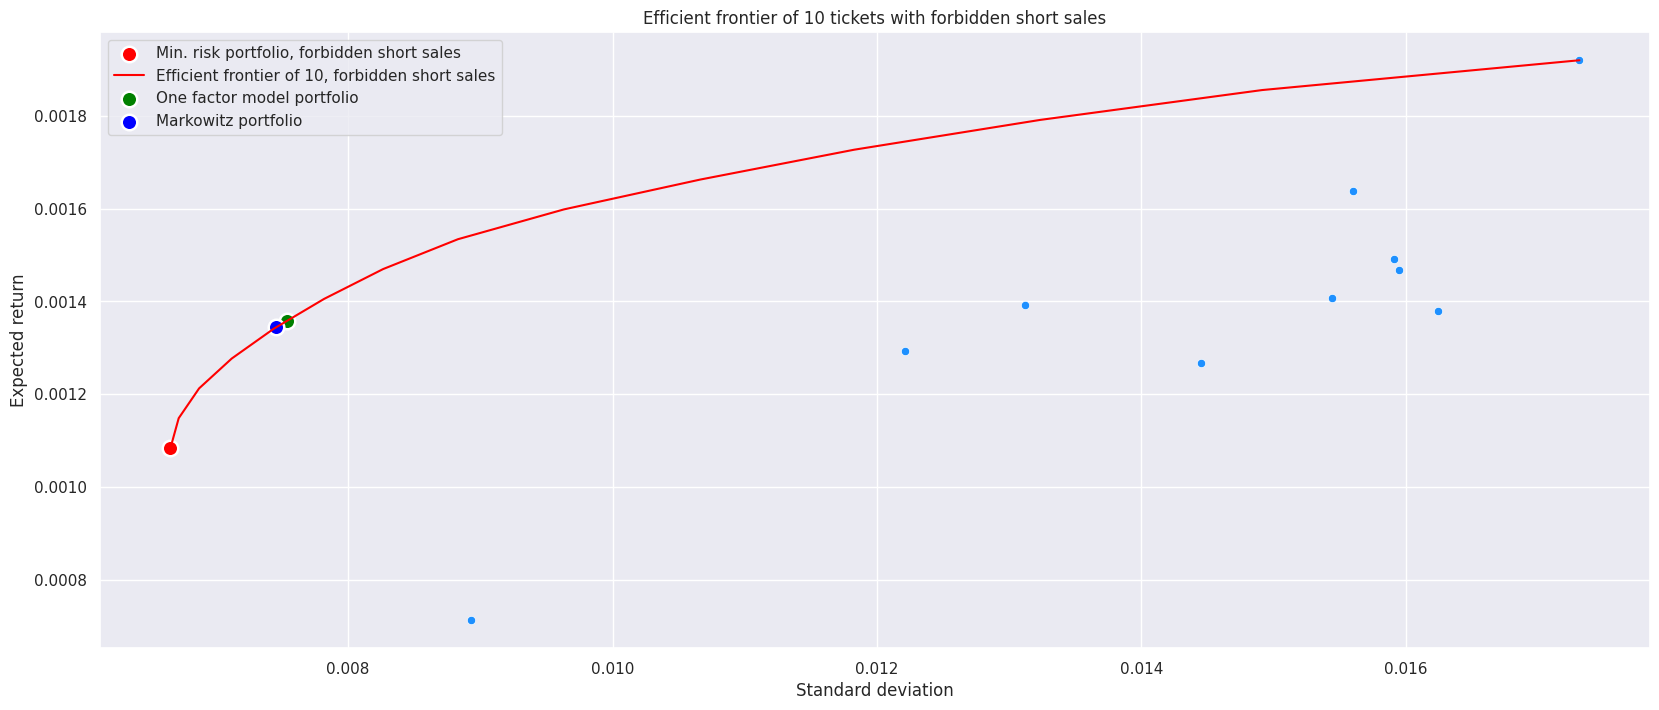

In [19]:
plt.figure(figsize=(20,8))
plot_efficient_frontier(stock_characteristics, min_risk_portfolio_std, min_risk_portfolio_return, portfolio_stds, portfolio_returns, short_sales=False)
sns.scatterplot(x=[opt_portfolio_std], y=[opt_portfolio_mean], marker='.', s=500, label='One factor model portfolio', color='green')
sns.scatterplot(x=[markowitz_std], y=[markowitz_mean], marker='.', s=500, label='Markowitz portfolio', color='blue')
plt.title('Efficient frontier of 10 tickets with forbidden short sales')
plt.show()

В общем случае аналитически нельзя получить оптимальный портфель по однофакторной модели, но в рассматриваемом случае эффективные фронты при запрете и разрешении коротких продаж практически совпадают в начале, поэтому и в случае коротких продаж портфель попал на эффективный фронт (но это лишь совпадение).

# Задание 6

Составим матрицу для проверки арбитражных возможностей.

In [27]:
matrix = pd.DataFrame({'E' : stock_characteristics_estimated.MEAN_RETURN.to_list(),
                    '1' : np.ones((len(beta),)),
                    'beta' : beta},
                    index=stock_characteristics_estimated.SECID)

matrix

,E,1,beta
SECID,,,
NVTK,0.001920,1.0,0.900237
NKNCP,0.001392,1.0,0.354608
AGRO,0.001292,1.0,0.382360
TATN,0.001638,1.0,0.882077
LKOH,0.001491,1.0,1.099721
ROSN,0.001467,1.0,0.932457
SIBN,0.001407,1.0,0.630131
SNGSP,0.001268,1.0,0.604586
TATNP,0.001380,1.0,0.528478


Если посчитать ранг полученной матрицы, то получим 3, что соответствует наличию арбитража. Однако, если посчитаем сингулярные числа матрицы, то увидим, что третье значение близко к нулю, что означает слабый арбитраж.

In [52]:
np.linalg.matrix_rank(matrix)

3

In [18]:
singular_values = np.linalg.svd(matrix).S
print(singular_values[0], singular_values[1], singular_values[2], sep='\n')

3.815917010375182
0.7022009139506368
0.0006530945141552352


Попробуем построить арбитражный портфель. Сначала построим матрицу доходностей портфелей из двух активов с нулевым риском. 

In [28]:
num_stocks = len(beta)
pairwise_portfolios_returns = pd.DataFrame(np.zeros((num_stocks, num_stocks)), 
                                           columns=stock_characteristics.index,
                                           index=stock_characteristics.index)
for i in range(num_stocks):
    for j in range(i + 1, num_stocks):
        pairwise_portfolios_returns.iloc[i, j] = (alpha[i] * beta[j] - alpha[j] * beta[i]) / (beta[j] - beta[i])
        pairwise_portfolios_returns.iloc[j, i] = pairwise_portfolios_returns.iloc[i, j]

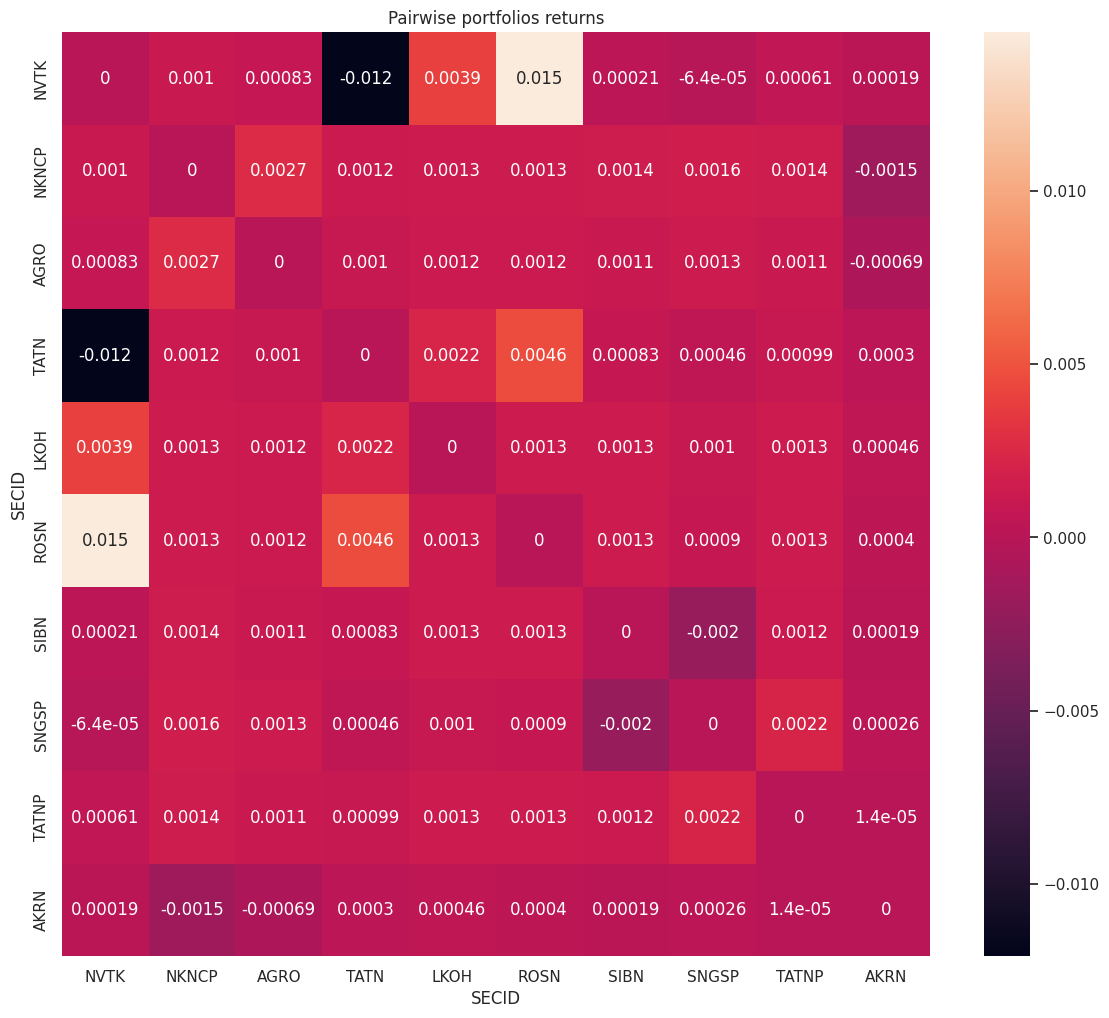

In [54]:
plt.figure(figsize=(14, 12))
sns.heatmap(pairwise_portfolios_returns, annot=True)

plt.title('Pairwise portfolios returns')
plt.show()

Минимальная доходность получилась у портфеля, состоящего из NVTK и TATN, максимальная - у портфеля из NVTK и ROSN. Попробуем решить задачу оптимизации на этих активах и найти портфель, у которого сумма долей этих активов будет 0 и скалярное произведение долей и коэффициентов $\beta$ также 0 (занулим доходности фактора в итоговом портфеле, чтобы портфель был константным).

In [191]:
secids = ['NVTK', 'TATN', 'ROSN']

In [192]:
def objective(x, mean_return):
    return - np.dot(mean_return, x)

num_stocks = len(secids)
X = np.ones((num_stocks))
X = X / X.sum()
bounds = ((-1.0, 1.0), ) * num_stocks
constraints = []
constraints.append({'type':'eq', 'fun': lambda X: np.sum(X) - 0.0})
constraints.append({'type':'eq', 'fun': lambda X: np.dot(X, matrix.loc[secids].beta) - 0.0})
x = minimize(objective, X, args=(stock_characteristics.loc[secids].MEAN_RETURN), method='SLSQP', constraints=constraints, bounds=bounds).x

In [193]:
pd.DataFrame({'secid' : secids, 'weights' : x})

,secid,weights
0,NVTK,0.000223
1,TATN,-0.000143
2,ROSN,-0.000081


Доли получились маленькие, но их увеличение приведет к увеличению риска, соответственно портфель будет не арбитражный.

In [204]:
- objective(x, stock_characteristics.loc[secids].MEAN_RETURN)

7.683342455988331e-08

Получился портфель с положительной, но очень маленькой доходностью. Можно сделать вывод, что арбитражные возможности на рынке из выбранных 10 активов есть, но доходность будет очень маленькая (на что ранее указывал близкое к нулю третье сингулярное число).